In [1]:
import matplotlib.pyplot as plt

from cmb.configs.experiments import Configs
from cmb.data.jetclass import CouplingData
from cmb.dynamics.cfm import ConditionalFlowMatching

config = Configs('epic.yaml')
jets = CouplingData(config=config.data, standardize=False)
dynamics = ConditionalFlowMatching(config.dynamics)

config.print()

2024-09-18 23:14:39.880546: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-18 23:14:39.924623: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-18 23:14:39.925564: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 23:14:40.723663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


general:
    workdir: ../../results
    experiment_name: beta_to_tops_ConditionalFlowMatching_EPiC_2024.09.18_23h14
data:
    dataset: JetClass
    target:
        name: tops
        path: ['/home/df630/CMB/data/JetClass/TTBar_000.root']
    source:
        name: beta
        concentration: [1.0, 10.0]
        path: None
    min_num_particles: 0
    max_num_particles: 128
    dim:
        continuous: 3
        discrete: 0
        context: 0
model:
    name: EPiC
    num_blocks: 6
    dim:
        hidden:
            local: 128
            glob: 10
        emb:
            time: 16
            continuous: None
            discrete: None
            context: None
    embedding:
        time: sinusoidal
        continuous: None
        discrete: None
        context: None
    skip_connection: True
    dropout: 0.1
    activation: GELU
train:
    device: cuda:1
    multi_gpu: False
    batch_size: 256
    data_split_frac: [0.8, 0.2, 0.0]
    epochs: 100
    early_stopping: None
    min_epo

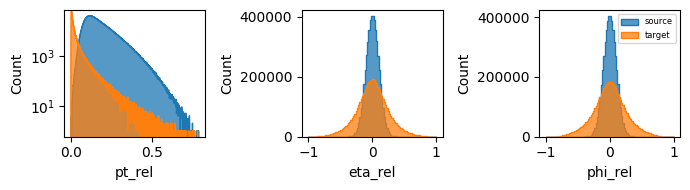

In [2]:
fig, ax = plt.subplots(1,3, figsize=(7,2))
jets.source.histplot('pt_rel', ax=ax[0], log_scale=(False,True))
jets.target.histplot('pt_rel', ax=ax[0], log_scale=(False,True))
jets.source.histplot('eta_rel', binrange=(-1,1), binwidth=0.02, ax=ax[1])
jets.target.histplot('eta_rel', binrange=(-1,1), binwidth=0.02,ax=ax[1])
jets.source.histplot('phi_rel', binrange=(-1,1), binwidth=0.02,ax=ax[2], label='source')
jets.target.histplot('phi_rel',binrange=(-1,1), binwidth=0.02, ax=ax[2], label='target')
ax[2].legend(fontsize=6)
plt.tight_layout()
plt.show()

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.nn.utils.weight_norm as weight_norm

from cmb.models.architectures.utils import (fc_block, 
                                            get_activation_function, 
                                            KANLinear, KAN,
                                            SinusoidalPositionalEncoding,
                                            GaussianFourierFeatures)

class EPiC(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.device = config.train.device

        #...input dimensions:
        dim_continuous = config.data.dim.continuous
        dim_discrete = config.data.dim.discrete
        dim_context = config.data.dim.context

        #...embedding dimensions:
        dim_time_emb = config.model.dim.emb.time
        dim_continuous_emb = config.model.dim.emb.continuous
        dim_discrete_emb = config.model.dim.emb.discrete
        dim_context_emb = config.model.dim.emb.context
        
        #...hidden dimensions:
        dim_hidden = config.model.dim.hidden.local
        dim_hidden_global = config.model.dim.hidden.glob

        #...model params:
        self.num_blocks = config.model.num_blocks
        self.skip_connection = config.model.skip_connection

        #...components:
        self.time_embedding = SinusoidalPositionalEncoding(dim_time_emb) # KANLinear(1, dim_time_emb) #
        self.epic_proj = EPiC_Projection(latent_local=dim_continuous + dim_time_emb,
                                         dim_latent_global=dim_hidden_global,
                                         dim_hidden=dim_hidden)

        self.epic_layers = nn.ModuleList()

        for _ in range(self.num_blocks):
            self.epic_layers.append(EPiC_layer(local_in_dim=dim_hidden, 
                                               hid_dim=dim_hidden,
                                               latent_dim=dim_hidden_global))
            
        #...output layer:

        self.output = weight_norm(nn.Linear(dim_hidden, dim_continuous))
                                                
    def forward(self, t, x, k=None, context=None, mask=None):
        t = t.to(self.device) # time
        x = x.to(self.device) # continuous feature (b, n, dim_continuous) 
        k = k.to(self.device) if k is not None else None  # discrete feature (b, n, dim_discrete)      
        mask = mask.to(self.device)

        #...emebdding layer:
        t_emb = self.time_embedding(t.squeeze(-1))  # (batch_size, dim_time_emb)
        t_emb = t_emb.unsqueeze(1).repeat(1, x.shape[1], 1)  # Repeat for each particle -> (batch_size, N, dim_time_emb)
        x_local = torch.cat([t_emb, x], dim=-1)  # (batch_size, N, dim_time_emb + dim_continuous)

        #...local to global:

        x_global, x_local = self.epic_proj(x_local)

        if self.skip_connection:
            x_global_skip = x_global.clone() 
            x_local_skip = x_local.clone()

        #...equivariant layers:
            
        for i in range(self.num_blocks):
            x_global, x_local = self.epic_layers[i](x_global, x_local)   
            if self.skip_connection:
                x_global += x_global_skip 
                x_local += x_local_skip
    
        output = self.output(x_local)
        
        return output     #[batch, points, feats]



class EPiC_Projection(nn.Module):
    def __init__(self, latent_local, dim_latent_global, dim_hidden):
        super(EPiC_Projection, self).__init__()

        # self.local_0 = nn.Sequential(KANLinear(latent_local, dim_hidden), nn.LayerNorm(dim_hidden))  # local projection_mlp
        # self.global_0 = nn.Sequential(KANLinear(2*dim_hidden, dim_hidden), nn.LayerNorm(dim_hidden)) # local to global projection_mlp
        # self.global_1 = nn.Sequential(KANLinear(dim_hidden, dim_hidden), nn.LayerNorm(dim_hidden))
        # self.global_2 = nn.Sequential(KANLinear(dim_hidden, dim_latent_global), nn.LayerNorm(dim_latent_global))

        self.local_0 = weight_norm(nn.Linear(latent_local, dim_hidden))  # local projection_mlp
        self.global_0 = weight_norm(nn.Linear(2*dim_hidden, dim_hidden)) # local to global projection_mlp
        self.global_1 = weight_norm(nn.Linear(dim_hidden, dim_hidden))
        self.global_2 = weight_norm(nn.Linear(dim_hidden, dim_latent_global))

    def meansum_pooling(self, x_local):
        x_mean = x_local.mean(1, keepdim=False)
        x_sum = x_local.sum(1, keepdim=False) 
        x_global = torch.cat([x_mean, x_sum], 1) 
        return x_global

    def forward(self, x_local):
        x_local = F.leaky_relu(self.local_0(x_local)) 
        x_global = self.meansum_pooling(x_local)
        x_global = F.leaky_relu(self.global_0(x_global))      
        x_global = F.leaky_relu(self.global_1(x_global))
        x_global = F.leaky_relu(self.global_2(x_global))   
        return x_global, x_local

class EPiC_layer(nn.Module):
    # from https://github.com/uhh-pd-ml/EPiC-GAN/blob/main/models.py
    def __init__(self, local_in_dim, hid_dim, latent_dim, context_dim=0):
        super(EPiC_layer, self).__init__()
        # self.fc_global1 = nn.Sequential(KANLinear(int(2*hid_dim) + latent_dim, hid_dim), nn.LayerNorm(hid_dim)) 
        # self.fc_global2 = nn.Sequential(KANLinear(hid_dim, latent_dim), nn.LayerNorm(latent_dim)) 
        # self.fc_local1 = nn.Sequential(KANLinear(local_in_dim + latent_dim + context_dim, hid_dim), nn.LayerNorm(hid_dim))
        # self.fc_local2 = nn.Sequential(KANLinear(hid_dim, hid_dim), nn.LayerNorm(hid_dim))

        self.fc_global1 = weight_norm(nn.Linear(int(2*hid_dim) + latent_dim, hid_dim)) 
        self.fc_global2 = weight_norm(nn.Linear(hid_dim, latent_dim)) 
        self.fc_local1 = weight_norm(nn.Linear(local_in_dim + latent_dim + context_dim, hid_dim))
        self.fc_local2 = weight_norm(nn.Linear(hid_dim, hid_dim))


    def forward(self, x_global, x_local, context=None):   # shapes: x_global.shape=[b, latent], x_local.shape = [b, num_points, latent_local]
        _, num_points, _ = x_local.size()
        dim_latent_global = x_global.size(1)

        x_pooled_sum = x_local.sum(1, keepdim=False)
        x_pooled_mean = x_local.mean(1, keepdim=False)
        x_pooledCATglobal = torch.cat([x_pooled_mean, x_pooled_sum, x_global], dim=-1)
        x_global1 = F.leaky_relu(self.fc_global1(x_pooledCATglobal))  # new intermediate step
        x_global = F.leaky_relu(self.fc_global2(x_global1) + x_global) # with residual connection before AF
        x_global2local = x_global.view(-1,1,dim_latent_global).repeat(1,num_points,1) # first add dimension, than expand it
        x_localCATglobal = torch.cat([x_local, x_global2local], 2)
        if context is not None:
            x_localCATglobal = torch.cat([x_localCATglobal, context], 2)
        x_local1 = F.leaky_relu(self.fc_local1(x_localCATglobal))  # with residual connection before AF
        x_local = F.leaky_relu(self.fc_local2(x_local1) + x_local)

        return x_global, x_local

class ParticleEmbedding(nn.Module):
    def __init__(self, 
                 time_embedding='sinusoidal', 
                 continuous_embedding=None,
                 discrete_embedding=None,
                 context_embedding=None,
                 dim_time=1,
                 dim_time_emb=16,
                 dim_continuous=None,
                 dim_continuous_emb=None,
                 vocab_size=None,
                 dim_discrete_emb=None,                 
                 dim_context=None,
                 dim_context_emb=None):
        # Call the parent nn.Module's init first
        super(ParticleEmbedding, self).__init__()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Set device here if needed
        
        if time_embedding == 'sinusoidal': 
            self.time_embedding = SinusoidalPositionalEncoding(dim_time, max_period=10000)
        elif time_embedding == 'randomfourier': 
            self.time_embedding = GaussianFourierFeatures(dim_time, scale=0.5)
        elif time_embedding == 'kolmogorov-arnold': 
            self.time_embedding = KANLinear(dim_time, dim_time_emb)
        elif time_embedding == 'linear': 
            self.time_embedding = nn.Linear(dim_time, dim_time_emb)  

        if continuous_embedding == 'kolmogorov-arnold': 
            self.continuous_embedding = KANLinear(dim_continuous, dim_continuous_emb)
        elif continuous_embedding == 'linear': 
            self.continuous_embedding = nn.Linear(dim_continuous, dim_continuous_emb)  

        if context_embedding == 'kolmogorov-arnold': 
            self.context_embedding = KANLinear(dim_context, dim_context_emb)
        elif context_embedding == 'linear': 
            self.context_embedding = nn.Linear(dim_context, dim_context_emb)  

        if discrete_embedding == 'embedding': 
            self.discrete_embedding = nn.Embedding(vocab_size, dim_discrete_emb)


    def forward(self, t, x, k=None, context=None, mask=None):
        """
        Forward pass of the particle embedding.

        Arguments:
        - t: Time input of shape (batch_size, 1) or (batch_size, 1, 1)
        - x: Particle continuous features of shape (batch_size, max_num_particles, dim_continuous)
        - mask: Binary mask of shape (batch_size, max_num_particles, 1) indicating valid particles (1) or masked particles (0)

        Returns:
        - h: Embedded particles of shape (batch_size, N, dim_hidden), masked appropriately

        """
        t_emb = self.time_embedding(t.unsqueeze(-1))if hasattr(self, 'time_embedding') else t # (batch_size, dim_time_emb)
        print('t_emb', t_emb.shape)
        t_emb = t_emb.unsqueeze(1).repeat(1, x.shape[1], 1)  # Repeat for each particle -> (batch_size, N, dim_time_emb)      
        print('t_emb_reshape', t_emb.shape)
        x_emb = self.continuous_embedding(x) if hasattr(self, 'continuous_embedding') else x
        print('x_emb', x_emb.shape)
        features = [t_emb, x_emb]
        

        if k is not None:
            k_emb = self.discrete_embedding(k).squeeze(1) if hasattr(self, 'discrete_embedding') else k
            features.append(k_emb)
        
        if context is not None:
            context_emb = self.context_embedding(context) if hasattr(self, 'context_embedding') else context
            features.append(context_emb)
        
        if mask is not None:
            mask = mask.to(self.device)

        h = torch.cat(features, dim=-1) * mask
        print('>', h.shape)
        return h

In [4]:
from cmb.models.trainers import CMBTrainer
epic = EPiC(config)
generative_model = CMBTrainer(config, dynamics, epic, jets)
generative_model.train()


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 80000, validation size: 20000, testing sizes: 0


number of training parameters: 475026
start training...


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
from cmb.models.pipelines import Pipeline

pipeline = Pipeline(trained_model=generative_model, config=config)
input = CouplingData(config.data)
pipeline.generate_samples(source_continuous=input.source.continuous[:400], mask=input.source.mask[:400])

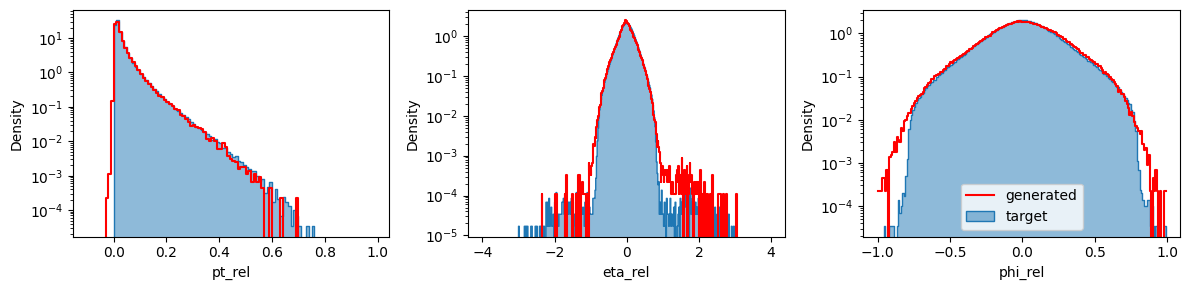

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

x_gen = pipeline.paths[-1].view(-1, 3).detach().cpu().numpy()
fig, ax = plt.subplots(1, 3, figsize=(12,3))

sns.histplot(x_gen[:,0],bins=np.arange(-.1, 1,0.01), ax=ax[0], color='r', log_scale=(False, True), fill=False, stat='density', element="step", label='generated')
jets.target.histplot('pt_rel',bins=np.arange(-.1, 1,0.01), ax=ax[0], log_scale=(False, True), stat='density', alpha=0.5, label='target')

sns.histplot(x_gen[:,1], bins=np.arange(-4, 4, 0.02), ax=ax[1], color='r', log_scale=(False, True), fill=False, stat='density', element="step",label='generated')
jets.target.histplot('eta_rel', bins=np.arange(-4, 4, 0.02),ax=ax[1], log_scale=(False, True), stat='density', alpha=0.5, label='target')

sns.histplot(x_gen[:,2], bins=np.arange(-1, 1,0.01), ax=ax[2], color='r', log_scale=(False, True), fill=False, stat='density', element="step",  label='generated')
jets.target.histplot('phi_rel', bins=np.arange(-1, 1,0.01), ax=ax[2], log_scale=(False, True), stat='density', alpha=0.5, label='target')

ax[2].legend()
plt.tight_layout()
plt.show()

In [8]:
pipeline.paths[-1].shape

torch.Size([3000, 128, 3])

In [14]:
jets = JetClassDataClass(config, discrete_features=True, standardize=True) 

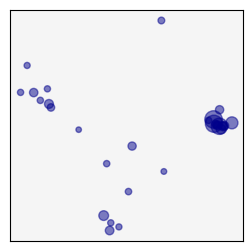

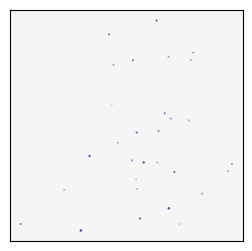

In [7]:
jets.target.display_cloud(idx=0)
jets.source.display_cloud(idx=0)

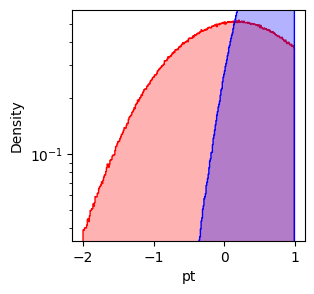

In [17]:
fig, ax = plt.subplots(figsize=(3,3))  
jets.target.histplot('pt', bins=np.arange(-2, 1,0.01), color='r', stat='density',alpha=0.3, label='target', log_scale=(False,True), ax=ax)
jets.source.histplot('pt', bins=np.arange(-2, 1,0.01), color='b', stat='density',alpha=0.3, label='target', log_scale=(False,True), ax=ax)

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


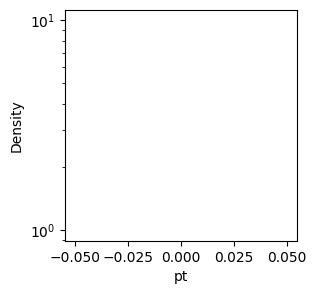

In [8]:
fig, ax = plt.subplots(figsize=(3,3))  
jets.source.histplot('pt', bins=np.arange(0, 1,0.01), color='b', idx=0, stat='density',alpha=0.3, label='target', log_scale=(False,True), ax=ax)
jets.target.histplot('pt', bins=np.arange(0, 1,0.01), color='r', idx=0, stat='density',alpha=0.3, label='target', log_scale=(False,True), ax=ax)

<Axes: ylabel='Count'>

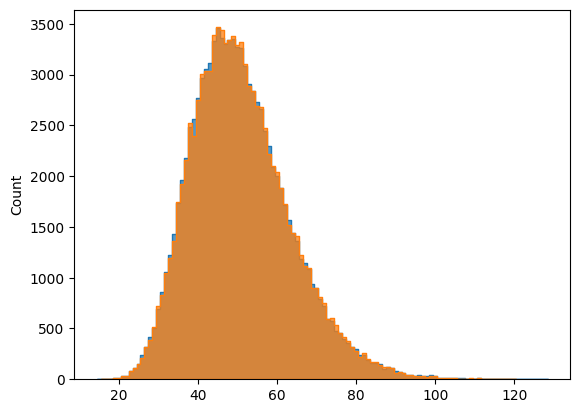

In [7]:
sns.histplot(jets.target.multiplicity, element='step', discrete=True)
sns.histplot(jets.source.multiplicity, element='step', discrete=True)